<a href="https://colab.research.google.com/github/kamrun301/301_demo/blob/main/lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import random
import math
import matplotlib.pyplot as plt


In [62]:

# Utility Functions
def argmaxall(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxall returns a list of all of the elements with maximal value.
    """
    maxv = -math.inf       # negative infinity
    maxvals = []      # list of maximal elements
    for (e,v) in gen:
        if v>maxv:
            maxvals,maxv = [e], v
        elif v==maxv:
            maxvals.append(e)
    return maxvals

def argmaxe(gen):
    """gen is a generator of (element,value) pairs, where value is a real.
    argmaxe returns an element with maximal value.
    If there are multiple elements with the max value, one is returned at random.
    """
    return random.choice(argmaxall(gen))

def argmax(lst):
    """returns maximum index in a list"""
    return argmaxe(enumerate(lst))

def argmaxd(dct):
   """returns the arg max of a dictionary dct"""
   return argmaxe(dct.items())

def flip(prob):
    """return true with probability prob"""
    return random.random() < prob

def select_from_dist(item_prob_dist):
    ranreal = random.random()
    for (it, prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(f"{item_prob_dist} is not a valid probability distribution")


In [63]:
class Displayable(object):
    max_display_level = 1   # can be overridden in subclasses or instances

    def display(self, level, *args, **nargs):
        if level <= self.max_display_level:
            print(*args, **nargs)

class Plot_history(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag, env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Value")

    def plot_env_hist(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.price_history,label="Price")
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.legend()
        #plt.draw()

    def plot_agent_hist(self):
        """plot history of buying"""
        num = len(ag.buy_history)
        plt.bar(range(1,num+1), ag.buy_history, label="Bought")
        plt.legend()
        #plt.draw()

In [64]:

# Environment Class
class TP_env(Displayable):
    price_delta = [0, 0, 0, 21, 0, 20, 0, -64, 0, 0, 23, 0, 0, 0, -35,
                  0, 76, 0, -41, 0, 0, 0, 21, 0, 5, 0, 5, 0, 0, 0, 5, 0, -15, 0, 5,
                  0, 5, 0, -115, 0, 115, 0, 5, 0, -15, 0, 5, 0, 5, 0, 0, 0, 5, 0,
                  -59, 0, 44, 0, 5, 0, 5, 0, 0, 0, 5, 0, -65, 50, 0, 5, 0, 5, 0, 0,
                  0, 5, 0]
    sd = 5  # noise standard deviation

    def __init__(self):
        self.time = 0
        self.stock = 20
        self.stock_history = []
        self.price_history = []

    def initial_percept(self):
        self.stock_history.append(self.stock)
        self.price = round(234 + self.sd * random.gauss(0, 1))
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}

    def do(self, action, time_unit):
        used = select_from_dist({6: 0.1, 5: 0.1, 4: 0.1, 3: 0.3, 2: 0.2, 1: 0.2})
        bought = action['buy']
        self.stock = self.stock + bought - used
        self.stock_history.append(self.stock)
        self.time += 1
        self.price = round(self.price
                           + self.price_delta[self.time % len(self.price_delta)]
                           + self.sd * random.gauss(0, 1))
        self.price_history.append(self.price)
        return {'price': self.price, 'instock': self.stock}

In [65]:
#Agent class
class TP_agent(Displayable):
    def __init__(self):
        self.spent = 0
        percept = env.initial_percept()
        self.ave = self.last_price = percept['price']
        self.instock = percept['instock']
        self.buy_history = []

    def select_action(self, percept):
        """Enhanced decision logic."""
        self.last_price = percept['price']
        self.ave = self.ave + (self.last_price - self.ave) * 0.05
        self.instock = percept['instock']

        if self.last_price < 500 and self.ave >= 600 and self.instock == 20:
           tobuy = 15
        elif self.instock < 10:
           tobuy = 10
        else:
            tobuy = 0

        self.spent += tobuy * self.last_price
        self.buy_history.append(tobuy)
        return {'buy': tobuy}



In [66]:
#Simulation class
class Simulate(Displayable):
    """Simulate the interaction between two agents and the environment for n time steps."""
    def __init__(self, agents, environment):
        self.agents = agents if isinstance(agents, list) else [agents]
       ## self.agents = agents  # List of agents
        self.env = environment
        self.percept = self.env.initial_percept()
        self.percept_history = [self.percept]
        self.action_history = []

    def go(self, n):
        for i in range(n):
            actions = []
            # Collect actions from all agents
            for agent in self.agents:
                action = agent.select_action(self.percept)
                actions.append(action)
                print(f"i={i} action={action}")

            # Combine actions from all agents (e.g., sum their 'buy' values)
            total_buy = sum(action['buy'] for action in actions)

            # Pass combined action to environment
            self.percept = self.env.do({'buy': total_buy}, i)
            print(f"      percept={self.percept}")


In [67]:
class Controller:
    """Controller class to manage interactions."""
    def __init__(self, agent, environment):
        self.agent = agent
        self.environment = environment

    def manage_stock(self, percept):
        """Decides on stock based on environment conditions."""
        return self.agent.select_action(percept)

    def monitor_environment(self, time_steps):
        """Simulates the environment and agent for given steps."""
        sim = Simulate(self.agent, self.environment)
        sim.go(time_steps)
        return sim


class CombinedController:
    """Manages the interaction between two controllers."""
    def __init__(self, controller1, controller2):
        self.controller1 = controller1
        self.controller2 = controller2

    def run_simulation(self, time_steps):
        """Simulates using both controllers."""
        sim1 = self.controller1.monitor_environment(time_steps // 2)
        sim2 = self.controller2.monitor_environment(time_steps // 2)
        return sim1, sim2


i=0 action={'buy': 0}
      percept={'price': 232, 'instock': 16}
i=1 action={'buy': 0}
      percept={'price': 238, 'instock': 11}
i=2 action={'buy': 0}
      percept={'price': 248, 'instock': 10}
i=3 action={'buy': 0}
      percept={'price': 247, 'instock': 7}
i=4 action={'buy': 10}
      percept={'price': 270, 'instock': 14}
i=5 action={'buy': 0}
      percept={'price': 273, 'instock': 8}
i=6 action={'buy': 10}
      percept={'price': 209, 'instock': 15}
i=7 action={'buy': 0}
      percept={'price': 209, 'instock': 12}
i=8 action={'buy': 0}
      percept={'price': 208, 'instock': 10}
i=9 action={'buy': 0}
      percept={'price': 227, 'instock': 9}
i=10 action={'buy': 10}
      percept={'price': 228, 'instock': 17}
i=11 action={'buy': 0}
      percept={'price': 233, 'instock': 14}
i=12 action={'buy': 0}
      percept={'price': 230, 'instock': 8}
i=13 action={'buy': 10}
      percept={'price': 191, 'instock': 15}
i=14 action={'buy': 0}
      percept={'price': 193, 'instock': 12}
i=15 

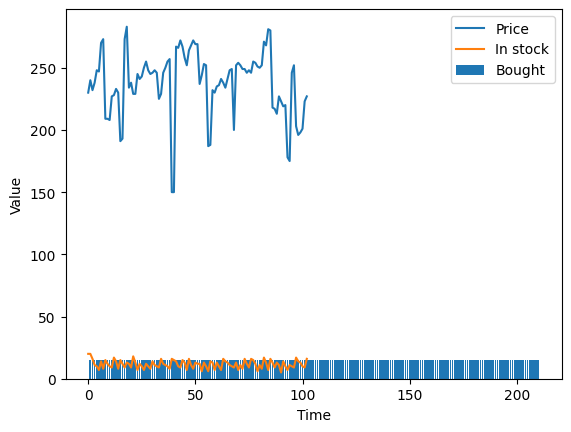

In [68]:
# Setting up environment, agent, and controllers
env = TP_env()
agent = TP_agent()
controller1 = Controller(agent, env)
controller2 = Controller(agent, env)
combined = CombinedController(controller1, controller2)

# Running simulation and plotting
sim1, sim2 = combined.run_simulation(100)

# Plotting
pl = Plot_history(agent, env)
pl.plot_env_hist()
pl.plot_agent_hist()
plt.show()
